In [18]:
# Inputs
REPO_ROOT = "../../"
clinvar_file = f"{REPO_ROOT}/processed_data/ClinVar/clinvar_indel_query_mapped_filter_significance_duplications_20230206.csv"

# Outputs
output_file = f"{REPO_ROOT}/outputs/output_scores/ClinVar_Levenshtein/output_full.csv"

In [54]:
import os

from Levenshtein import distance
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [20]:
assert os.path.isfile(clinvar_file), clinvar_file
assert os.path.isdir(os.path.dirname(output_file))

In [21]:
df = pd.read_csv(clinvar_file)
print(df.columns)
df.head()

Index(['Name', 'Gene(s)', 'Protein change', 'Condition(s)',
       'Clinical significance (Last reviewed)', 'Review status', 'Accession',
       'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome',
       'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID',
       'Canonical SPDI', 'Unnamed: 15', 'Stars', 'Clinical significance',
       'Last reviewed', 'hgvs_valid', 'protein_variant', 'inframe_dup',
       'inframe_synon_stop', 'question_mark', 'square_bracket',
       'hgvs_frameshift', 'invalid_aa', 'inframe_delins', 'inframe_ins',
       'inframe_del', 'aa_wt_start_3letter', 'pos_start', 'aa_wt_start',
       'protein_variant_1letter', 'refseq_id', 'refseq_protein_id', 'length',
       'definition', 'gene', 'gene_synonym', 'coded_by', 'note', 'CCDS',
       'GeneID', 'HGNC', 'MIM', 'GO_component', 'GO_function', 'GO_process',
       'IMGT/GENE-DB', 'exception', 'ribosomal_slippage', 'transl_table',
       'refseq_mrna_id', 'coding_pos', 'has_mrna_mapping', 'gene_symbol_

,Name,Gene(s),Protein change,Condition(s),Clinical significance (Last reviewed),Review status,Accession,GRCh37Chromosome,GRCh37Location,GRCh38Chromosome,...,protein_sequence,uniprot_id,protein_sequence_mutated,protein_seqlen,mutation_depth,filter_lt_3_aas,filter_lt_1022_seqlen,filter_lt_6000_seqlen,ClinSigSimple,is_repeating
0,NM_080605.4(B3GALT6):c.415_423del (p.Met139_Al...,B3GALT6,NaN,"Ehlers-Danlos syndrome, spondylodysplastic typ...","Pathogenic(Last reviewed: Jun 6, 2013)",no assertion criteria provided,VCV000060494,1,1168065 - 1168073,1,...,MKLLRRAWRRRAALGLGTLALCGAALLYLARCAAEPGDPRAMSGRS...,{'Q5T7M5'},MKLLRRAWRRRAALGLGTLALCGAALLYLARCAAEPGDPRAMSGRS...,329,-3,True,True,True,Pathogenic,False
1,NM_002074.5(GNB1):c.1011_1013del (p.Lys337_Ile...,GNB1,NaN,Inborn genetic diseases,"Pathogenic(Last reviewed: Apr 25, 2016)","criteria provided, single submitter",VCV000521025,1,1718780 - 1718782,1,...,MSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...,"{'Q1RMY8', 'A0A024R056'}",MSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...,340,-1,True,True,True,Pathogenic,False
2,NM_031475.3(ESPN):c.1803GCC[5] (p.Pro605dup),ESPN,NaN,Autosomal recessive nonsyndromic hearing loss ...,"Likely benign(Last reviewed: Jul 30, 2022)","criteria provided, multiple submitters, no con...",VCV001219107,1,6509036 - 6509037,1,...,MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,{'Q9Y329'},MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,854,1,True,True,True,Benign,True
3,NM_031475.3(ESPN):c.2539AAG[1] (p.Lys848del),ESPN,"K818del, K848del, K827del","Deafness, without vestibular involvement, auto...","Pathogenic(Last reviewed: Feb 1, 2006)",no assertion criteria provided,VCV000004423,1,6520179 - 6520181,1,...,MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,{'Q9Y329'},MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,854,-1,True,True,True,Pathogenic,False
4,NM_007262.5(PARK7):c.471_473del (p.Pro158del),PARK7,P158del,Autosomal recessive early-onset Parkinson dise...,"Likely pathogenic(Last reviewed: Aug 1, 2022)","criteria provided, multiple submitters, no con...",VCV000987356,1,8045015 - 8045017,1,...,MASKRALVILAKGAEEMETVIPVDVMRRAGIKVTVAGLAGKDPVQC...,"{'V9HWC2', 'Q7LFU2'}",MASKRALVILAKGAEEMETVIPVDVMRRAGIKVTVAGLAGKDPVQC...,189,-1,True,True,True,Pathogenic,False


In [22]:
df[["protein_sequence", "protein_sequence_mutated"]]

,protein_sequence,protein_sequence_mutated
0,MKLLRRAWRRRAALGLGTLALCGAALLYLARCAAEPGDPRAMSGRS...,MKLLRRAWRRRAALGLGTLALCGAALLYLARCAAEPGDPRAMSGRS...
1,MSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...,MSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...
2,MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...
3,MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...
4,MASKRALVILAKGAEEMETVIPVDVMRRAGIKVTVAGLAGKDPVQC...,MASKRALVILAKGAEEMETVIPVDVMRRAGIKVTVAGLAGKDPVQC...
...,...,...
2085,MADAEVIILPKKHKKKKERKSLPEEDVAEIQHAEEFLIKPESKVAK...,MADAEVIILPKKHKKKKERKSLPEEDVAEIQHAEEFLIKPESKVAK...
2086,MADAEVIILPKKHKKKKERKSLPEEDVAEIQHAEEFLIKPESKVAK...,MADAEVIILPKKHKKKKERKSLPEEDVAEIQHAEEFLIKPESKVAK...
2087,MQIELSTCFFLCLLRFCFSATRRYYLGAVELSWDYMQSDLGELPVD...,MQIELSTCFFLCLLRFCFSATRRYYLGAVELSWDYMQSDLGELPVD...
2088,MQIELSTCFFLCLLRFCFSATRRYYLGAVELSWDYMQSDLGELPVD...,MQIELSTCFFLCLLRFCFSATRRYYLGAVELSWDYMQSDLGELPVD...


In [23]:
%%time
# Add a column of scores
def calc_distance(row_tuple):
    return distance(row_tuple.protein_sequence, row_tuple.protein_sequence_mutated)

df["edit_distance_levenshtein"] = list(map(calc_distance, df[["protein_sequence", "protein_sequence_mutated"]].itertuples()))

CPU times: user 14.8 ms, sys: 225 µs, total: 15 ms
Wall time: 14.4 ms


In [24]:
df

,Name,Gene(s),Protein change,Condition(s),Clinical significance (Last reviewed),Review status,Accession,GRCh37Chromosome,GRCh37Location,GRCh38Chromosome,...,uniprot_id,protein_sequence_mutated,protein_seqlen,mutation_depth,filter_lt_3_aas,filter_lt_1022_seqlen,filter_lt_6000_seqlen,ClinSigSimple,is_repeating,edit_distance_levenshtein
0,NM_080605.4(B3GALT6):c.415_423del (p.Met139_Al...,B3GALT6,NaN,"Ehlers-Danlos syndrome, spondylodysplastic typ...","Pathogenic(Last reviewed: Jun 6, 2013)",no assertion criteria provided,VCV000060494,1,1168065 - 1168073,1,...,{'Q5T7M5'},MKLLRRAWRRRAALGLGTLALCGAALLYLARCAAEPGDPRAMSGRS...,329,-3,True,True,True,Pathogenic,False,3
1,NM_002074.5(GNB1):c.1011_1013del (p.Lys337_Ile...,GNB1,NaN,Inborn genetic diseases,"Pathogenic(Last reviewed: Apr 25, 2016)","criteria provided, single submitter",VCV000521025,1,1718780 - 1718782,1,...,"{'Q1RMY8', 'A0A024R056'}",MSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...,340,-1,True,True,True,Pathogenic,False,2
2,NM_031475.3(ESPN):c.1803GCC[5] (p.Pro605dup),ESPN,NaN,Autosomal recessive nonsyndromic hearing loss ...,"Likely benign(Last reviewed: Jul 30, 2022)","criteria provided, multiple submitters, no con...",VCV001219107,1,6509036 - 6509037,1,...,{'Q9Y329'},MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,854,1,True,True,True,Benign,True,1
3,NM_031475.3(ESPN):c.2539AAG[1] (p.Lys848del),ESPN,"K818del, K848del, K827del","Deafness, without vestibular involvement, auto...","Pathogenic(Last reviewed: Feb 1, 2006)",no assertion criteria provided,VCV000004423,1,6520179 - 6520181,1,...,{'Q9Y329'},MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,854,-1,True,True,True,Pathogenic,False,1
4,NM_007262.5(PARK7):c.471_473del (p.Pro158del),PARK7,P158del,Autosomal recessive early-onset Parkinson dise...,"Likely pathogenic(Last reviewed: Aug 1, 2022)","criteria provided, multiple submitters, no con...",VCV000987356,1,8045015 - 8045017,1,...,"{'V9HWC2', 'Q7LFU2'}",MASKRALVILAKGAEEMETVIPVDVMRRAGIKVTVAGLAGKDPVQC...,189,-1,True,True,True,Pathogenic,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,NM_001363.5(DKC1):c.1494GAA[5] (p.Lys504_Lys50...,DKC1,NaN,Dyskeratosis congenita,"Benign(Last reviewed: Nov 13, 2020)","criteria provided, single submitter",VCV000800273,X,154005089 - 154005094,X,...,{'Q9Y505'},MADAEVIILPKKHKKKKERKSLPEEDVAEIQHAEEFLIKPESKVAK...,514,-2,True,True,True,Benign,True,2
2086,NM_001363.5(DKC1):c.1512_1513insGAA (p.Lys504_...,DKC1,NaN,not provided,"Benign(Last reviewed: Mar 3, 2015)","criteria provided, single submitter",VCV001244861,X,154005109 - 154005110,X,...,{'Q9Y505'},MADAEVIILPKKHKKKKERKSLPEEDVAEIQHAEEFLIKPESKVAK...,514,1,True,True,True,Benign,True,1
2087,NM_000132.4(F8):c.6670_6672del (p.Pro2224del),F8,"P2224del, P89del",Hereditary factor VIII deficiency disease,"Pathogenic(Last reviewed: Dec 1, 1993)",no assertion criteria provided,VCV000010323,X,154090044 - 154090046,X,...,{'Q5HY69'},MQIELSTCFFLCLLRFCFSATRRYYLGAVELSWDYMQSDLGELPVD...,2351,-1,True,False,True,Pathogenic,False,1
2088,NM_000132.4(F8):c.2009TCT[2] (p.Phe672del),F8,F672del,Hereditary factor VIII deficiency disease,"Pathogenic(Last reviewed: Feb 1, 1993)",no assertion criteria provided,VCV000010243,X,154176069 - 154176071,X,...,{'Q5HY69'},MQIELSTCFFLCLLRFCFSATRRYYLGAVELSWDYMQSDLGELPVD...,2351,-1,True,False,True,Pathogenic,False,1


In [25]:
df["label_pathogenic"] = (df["ClinSigSimple"] == "Pathogenic")

## Explore labels

In [26]:
prop_pathogenic = df["label_pathogenic"].mean()
prop_pathogenic

0.8421052631578947

<AxesSubplot: xlabel='label_pathogenic', ylabel='edit_distance_levenshtein'>

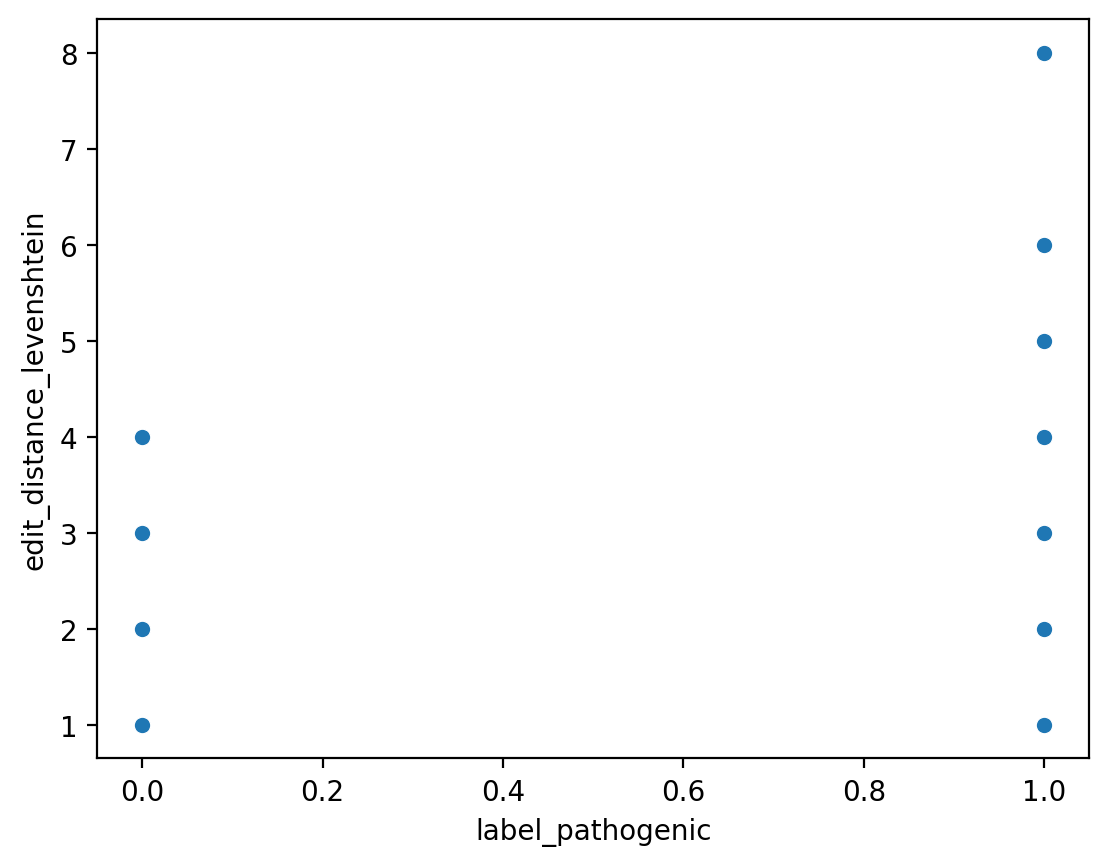

In [27]:
sns.scatterplot(x="label_pathogenic", y="edit_distance_levenshtein", data=df)

In [28]:
spearmanr(df["edit_distance_levenshtein"], df["label_pathogenic"])

SpearmanrResult(correlation=-0.044107677886685376, pvalue=0.04377652341198726)

In [29]:
df["label_pathogenic"]

0        True
1        True
2       False
3        True
4        True
        ...  
2085    False
2086    False
2087     True
2088     True
2089     True
Name: label_pathogenic, Length: 2090, dtype: bool

In [30]:
df["edit_distance_levenshtein"].head(10)

0    3
1    2
2    1
3    1
4    1
5    1
6    1
7    1
8    3
9    1
Name: edit_distance_levenshtein, dtype: int64

4.0

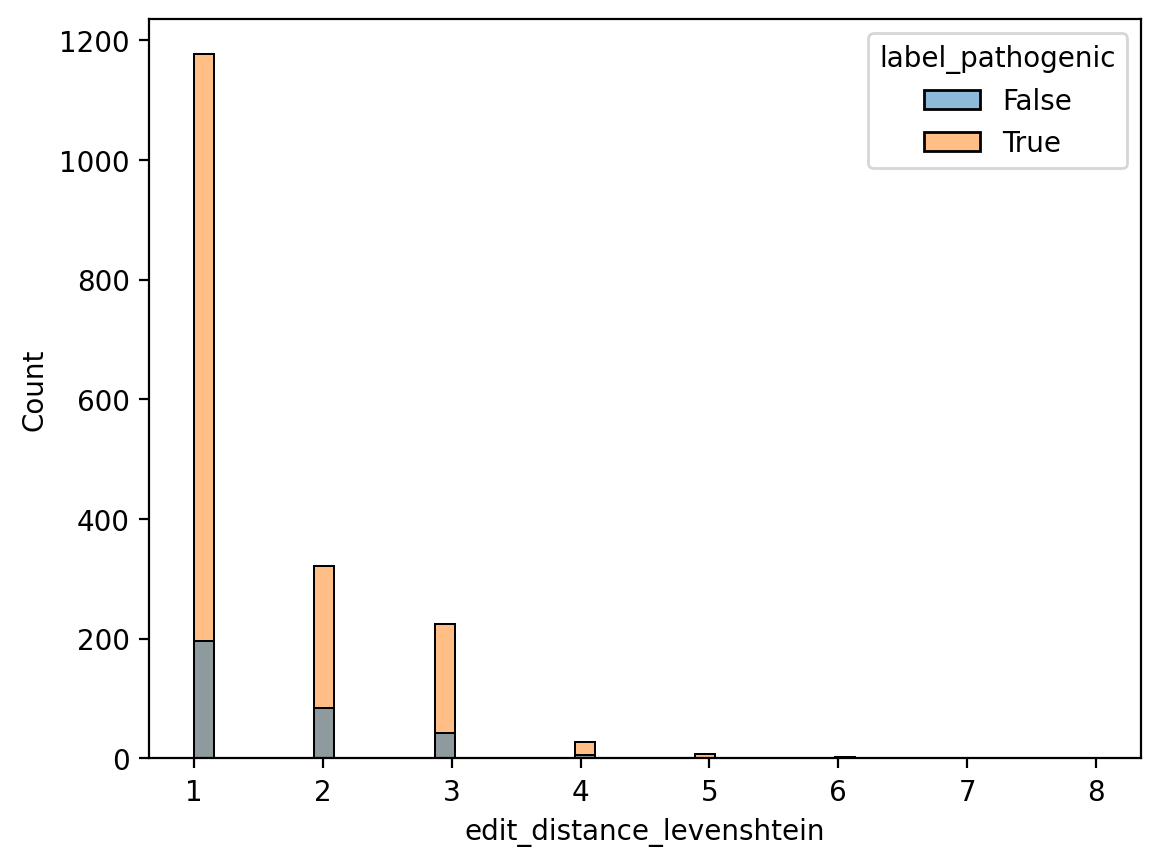

In [31]:

sns.histplot(x="edit_distance_levenshtein", data=df, hue='label_pathogenic')
# Choose a cutoff
df["edit_distance_levenshtein"].astype(float).quantile(0.98)

<AxesSubplot: xlabel='edit_distance_levenshtein', ylabel='label_pathogenic'>

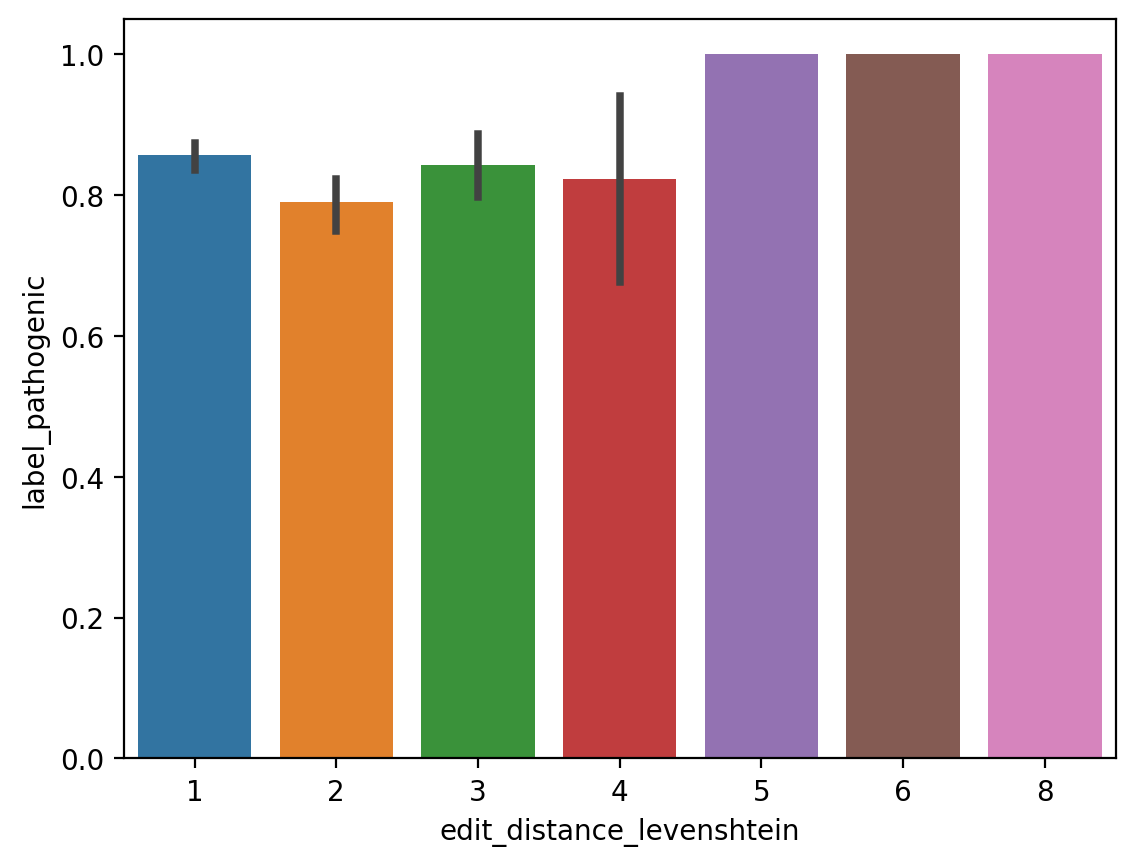

In [32]:
sns.barplot(x="edit_distance_levenshtein", y="label_pathogenic", data=df, orient='v')

In [33]:
# If bin above cutoff, return 1, if bin below, return 0, if same bin, return a proportion
def fuzzy_binning(binned_series, percentile):
    pct_bin = binned_series.quantile(percentile)
    # The amount of probability in the bins below
    probability_below = (binned_series < pct_bin).mean()
    assert probability_below <= percentile

    probability_above = (binned_series > pct_bin).mean()
    assert probability_above >= percentile

    prob_remaining = percentile - probability_below

    bin_size = (binned_series == int(pct_bin)).mean()
    prob_remaining_bin = prob_remaining / bin_size

    assert prob_remaining
    def get_bin(x):
        if x > pct_bin:
            return 1
        elif x < pct_bin:
            return 0
        elif x == pct_bin:
            return prob_remaining_bin
    return get_bin

import numpy as np

def fuzzy_quantile(binned_series, quantile):
    # Calculate the bin containing the quantile value
    bin_index = int(binned_series.quantile(quantile, interpolation="nearest"))
    print("tmp quantile:", binned_series.quantile(quantile))
    print("bin index:", bin_index)

    # Determine the amount of probability in the lower/upper bins
    total = len(binned_series)
    probability_below = ((binned_series < bin_index).sum())/(total)
    probability_above = ((binned_series > bin_index).sum())/(total)

    print(f"Prob below: {probability_below}, prob_above {probability_above}")

    assert probability_below <= quantile, (probability_below, quantile)
    assert 1-probability_above >= quantile, (1-probability_above, quantile)
    assert 1-probability_above >= probability_below

    probability_within_bin = (1-probability_above) - probability_below
    print("Probability within bin", probability_within_bin)
    probability_below_quantile_within_bin = (quantile - probability_below) / (probability_within_bin)
    print("probability quantile within bin", probability_below_quantile_within_bin)

    def get_fuzzy_bin(x):
        assert x == int(x)
        if x > bin_index:
            return 1
        elif x < bin_index:
            return 0
        elif x == bin_index:
            return probability_below_quantile_within_bin

    return get_fuzzy_bin

test_series = pd.Series([1, 1, 2, 2, 3, 3, 4, 5])
bin_func = fuzzy_quantile(test_series, 0.80) # The lower 2 is the 3/7th quantile

bin_func(3)

tmp quantile: 3.6000000000000005
bin index: 4
Prob below: 0.75, prob_above 0.125
Probability within bin 0.125
probability quantile within bin 0.40000000000000036


0

# Get scores

In [49]:
display(df["edit_distance_levenshtein"].value_counts(normalize=True).sort_index())

print("cumulative probs:", df["edit_distance_levenshtein"].value_counts(normalize=True).sort_index().cumsum())

1    0.656938
2    0.194258
3    0.127751
4    0.016268
5    0.003349
6    0.000957
8    0.000478
Name: edit_distance_levenshtein, dtype: float64

cumulative probs: 1    0.656938
2    0.851196
3    0.978947
4    0.995215
5    0.998565
6    0.999522
8    1.000000
Name: edit_distance_levenshtein, dtype: float64


In [40]:
sorted_counts = df["edit_distance_levenshtein"].value_counts(normalize=True).sort_index()
sorted_counts.iloc[0]

0.6569377990430622

In [48]:
def fuzzy_quantile_counts(sorted_counts, quantile):
    # Let's do this the slow way
    prob_cumulative = 0
    for i in range(len(sorted_counts)):
        prob = sorted_counts.values[i]
        if prob_cumulative + prob >= quantile:
            # The quantile falls in this next bin
            index_found = i
            break
        else:
            prob_cumulative += prob
    
    prob_below = prob_cumulative
    bin_value, prob_within_bin = sorted_counts.index[index_found], sorted_counts.iloc[index_found]
    quantile_within_bin = (quantile - prob_cumulative) / prob_within_bin
    assert 0 <= quantile_within_bin <= 1

    def fuzzy_func(x):
        if x < bin_value:
            return 0
        elif x == bin_value:
            return quantile_within_bin
        else: 
            return 1
    return fuzzy_func

sorted_counts = df["edit_distance_levenshtein"].value_counts(normalize=True).sort_index()
f = fuzzy_quantile_counts(sorted_counts, prop_pathogenic)

f(2)

0.9532019704433498

In [50]:
df["fuzzy_edit_score"] = df["edit_distance_levenshtein"].apply(f)

In [51]:
spearmanr(df["fuzzy_edit_score"], df["label_pathogenic"])

SpearmanrResult(correlation=-0.044541391264327136, pvalue=0.04174336833002316)

In [56]:
roc_auc_score(y_score=df["fuzzy_edit_score"], y_true=df["label_pathogenic"])

0.47037448347107436

In [57]:
roc_auc_score(y_score=df["edit_distance_levenshtein"], y_true=df["label_pathogenic"])

0.47063791322314047

In [59]:
roc_auc_score(y_score=[prop_pathogenic]*len(df), y_true=df["label_pathogenic"])

0.5